In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import pandas as pd

In [3]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from wfdb import processing
import numpy as np

In [4]:
data = pd.read_csv("X_train.csv")

In [5]:
answers = pd.read_csv("y_train.csv")

In [6]:
data = (pd.merge(data ,answers, on = "Unnamed: 0"))
data['age'] = (data['age'] - data['age'].mean(axis = 0))/data['age'].std(axis = 0)

In [7]:
data = data.drop( ["Unnamed: 0"], axis = 1)

In [8]:
data.head()

,age,gender,i_0,i_1,i_2,i_3,i_4,i_5,i_6,i_7,...,v6_4991,v6_4992,v6_4993,v6_4994,v6_4995,v6_4996,v6_4997,v6_4998,v6_4999,axis_id
0,0.192357,1,-59.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,...,114.0,119.0,124.0,129.0,134.0,147.0,172.0,200.0,143.0,3
1,1.399105,0,-39.0,-38.0,-38.0,-38.0,-38.0,-38.0,-38.0,-38.0,...,229.0,259.0,289.0,319.0,349.0,379.0,409.0,439.0,302.0,3
2,0.137505,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,-38.0,-11.0,-2.0,2
3,1.344253,0,108.0,106.0,93.0,79.0,86.0,74.0,64.0,51.0,...,81.0,89.0,79.0,59.0,61.0,64.0,49.0,26.0,10.0,3
4,-1.453208,1,363.0,366.0,366.0,353.0,334.0,314.0,306.0,294.0,...,-61.0,-59.0,-86.0,-66.0,-71.0,-91.0,-84.0,-11.0,-4.0,0


In [9]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

In [10]:
signal_df = pd.read_csv("signal_data.csv", sep="#", index_col=False)

In [11]:
for column in signal_df.columns:
    signal_df[column] = signal_df[column].apply(lambda row: np.fromstring(row[1:-1], sep="  ", dtype=np.uint64))

In [12]:
window_size = 64
overlap = 32   

In [13]:
def get_spectrogramm(ecg, should_log = False, show = False):
    f,t,x = signal.spectral.spectrogram(
                        ecg, 
                        window=("tukey", 0.25),
                        nperseg=window_size, 
                        noverlap=overlap, 
                        return_onesided=True) 
    
            
    if (should_log):    
        x = np.log(x + 1e-8)
    x = x.astype(np.float32)
    
    if (show):
        plt.pcolormesh(t, f, x)

    return x

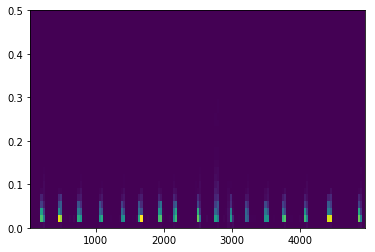

In [14]:
spectro = get_spectrogramm(data.values[0][2:5002], False, True)

In [15]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [16]:
from basics import *

In [17]:
class ECGDataset(FixedLengthDataset):
    def __init__(self, data, peaks, signal_length, min_start_offset = 50, max_start_offset = 300, low_cut = 5, high_cut = 20):
        super().__init__(data, peaks, signal_length, min_start_offset, max_start_offset, low_cut, high_cut)


    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        true_idx, cut_point = self.cut_points[idx]
        label = self._get_label(true_idx)
        cut_rows = self._cut(self.filtered_data[true_idx], cut_point)
        
        images = np.zeros((12,33,92), dtype=np.float32)
        for i in range(12):
            images[i] = get_spectrogramm(cut_rows[i])
        
        return images, label

In [18]:
class TestECGDataset(FixedLengthDataset):
    def __init__(self, data, peaks, signal_length, min_start_offset = 50, max_start_offset = 300, low_cut = 5, high_cut = 20):
        super().__init__(data, peaks, signal_length, min_start_offset, max_start_offset, low_cut, high_cut)
               
    def _get_cuts(self):
        cut_points = [ self._get_peaks_for_signal_cuts(peaks[0])  for peaks in self.peaks]
        self.cut_points = cut_points
        
    def __len__(self):
        return len(self.data)
        
        
    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        cut_point = np.random.choice(self.cut_points[idx])
        label = self._get_label(idx)
        cut_rows = self._cut(self.filtered_data[idx], cut_point)
        
        images = np.zeros((12,33,92), dtype=np.float32)
        for i in range(12):
            images[i] = get_spectrogramm(cut_rows[i])
        
        return images, label

In [19]:
dataset = TestECGDataset(data, signal_df, 3000)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [20]:
ecg_loader = DataLoader(dataset, batch_size= 2)

In [21]:
for i in ecg_loader:
    print(i[0].shape)
    print(i[1].argmax(dim=1))
    break

torch.Size([2, 12, 33, 92])
tensor([3, 3])


In [22]:
from torch.utils.data.sampler import SubsetRandomSampler

In [23]:
valid_size = 0.1
random_seed = 7

num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))


np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_dataset = ECGDataset(data.iloc[train_idx], signal_df.iloc[train_idx], 3000)
valid_dataset = TestECGDataset(data.iloc[valid_idx], signal_df.iloc[valid_idx], 3000)

In [24]:
batchsize = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle = True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batchsize, shuffle = True
)

In [25]:
import torch.nn as nn

In [26]:
class CNN(nn.Module):
    # (33, 92)
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(12, 32, kernel_size=3, stride=1),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU()) # (14, 44, 32)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU()) # (5, 20, 32)
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()) #(1, 8, 64)
        self.fc1 = nn.Linear(8*64, 100)
        self.fc2 = nn.Linear(100, 4)
        self.sm = nn.Softmax(dim = 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.sm(out)
        return out

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [28]:
model = CNN().to(device)

In [29]:
import torch.nn.functional as F

In [30]:
def validate():
    val_length = 0
    correct_answers = 0
    for i, data in enumerate(valid_loader, 0):
        # get the inputs
        (images, labels) = data
        images = images.to(device)
        labels = labels.to(device).argmax(dim = 1)

        # forward + backward + optimize
        outputs = model.forward(images)


        answer = outputs.argmax(dim = 1)

        res = answer == labels 

        #print(answer)
        ##print(res)
        #print(np.sum(res)/len(answer))
        val_length += len(answer)
        correct_answers += res.sum().float()
        
    return correct_answers/val_length

In [31]:
no_of_epochs = 150
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
total_step = len(train_loader)
for epoch in range(no_of_epochs):
    model.train()
    for i, (images, label) in enumerate(train_loader):
        images = images.to(device)
        label  = label.to(device).argmax(dim=1).long()

        # Forward Pass
        preds = model(images)
        loss = criterion(preds, label)
        
        if (epoch%3==0 and i % 10 == 9):
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, no_of_epochs, i+1, total_step, loss.item()))

        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    if (epoch%3 == 0):
        print('Epoch [{}/{}], Score: {}' 
                   .format(epoch+1, no_of_epochs, validate()))

Epoch [1/150], Step [10/57], Loss: 1.3748
Epoch [1/150], Step [20/57], Loss: 1.3584
Epoch [1/150], Step [30/57], Loss: 1.3262
Epoch [1/150], Step [40/57], Loss: 1.2712
Epoch [1/150], Step [50/57], Loss: 1.2236
Epoch [1/150], Score: 0.6000000238418579
Epoch [4/150], Step [10/57], Loss: 0.9919
Epoch [4/150], Step [20/57], Loss: 1.1009
Epoch [4/150], Step [30/57], Loss: 1.0561
Epoch [4/150], Step [40/57], Loss: 1.0368
Epoch [4/150], Step [50/57], Loss: 0.9762
Epoch [4/150], Score: 0.6153846383094788
Epoch [7/150], Step [10/57], Loss: 1.0124
Epoch [7/150], Step [20/57], Loss: 1.0142
Epoch [7/150], Step [30/57], Loss: 0.9824
Epoch [7/150], Step [40/57], Loss: 0.9868
Epoch [7/150], Step [50/57], Loss: 0.9528
Epoch [7/150], Score: 0.6307692527770996
Epoch [10/150], Step [10/57], Loss: 1.0494
Epoch [10/150], Step [20/57], Loss: 1.0513
Epoch [10/150], Step [30/57], Loss: 1.0871
Epoch [10/150], Step [40/57], Loss: 0.9797
Epoch [10/150], Step [50/57], Loss: 0.9819
Epoch [10/150], Score: 0.6923077

Epoch [94/150], Score: 0.6307692527770996
Epoch [97/150], Step [10/57], Loss: 0.8026
Epoch [97/150], Step [20/57], Loss: 0.8112
Epoch [97/150], Step [30/57], Loss: 0.7907
Epoch [97/150], Step [40/57], Loss: 0.8209
Epoch [97/150], Step [50/57], Loss: 0.8379
Epoch [97/150], Score: 0.6461538672447205
Epoch [100/150], Step [10/57], Loss: 0.7934
Epoch [100/150], Step [20/57], Loss: 0.7782
Epoch [100/150], Step [30/57], Loss: 0.8006
Epoch [100/150], Step [40/57], Loss: 0.8015
Epoch [100/150], Step [50/57], Loss: 0.8103
Epoch [100/150], Score: 0.6000000238418579
Epoch [103/150], Step [10/57], Loss: 0.8545
Epoch [103/150], Step [20/57], Loss: 0.8048
Epoch [103/150], Step [30/57], Loss: 0.7604
Epoch [103/150], Step [40/57], Loss: 0.7834
Epoch [103/150], Step [50/57], Loss: 0.7934
Epoch [103/150], Score: 0.5538461804389954
Epoch [106/150], Step [10/57], Loss: 0.7995
Epoch [106/150], Step [20/57], Loss: 0.8025
Epoch [106/150], Step [30/57], Loss: 0.7996
Epoch [106/150], Step [40/57], Loss: 0.8044

In [32]:
model.eval()
validate()

tensor(0.5538, device='cuda:0')

In [43]:
def get_preds_nad_true():
    y_pred = np.zeros((len(valid_dataset),))
    y_true = np.zeros((len(valid_dataset),))
    offset = 0
    for i, data in enumerate(valid_loader, 0):
        # get the inputs
        (images, labels) = data
        images = images.to(device)
        labels = labels.to(device).argmax(dim = 1)

        # forward + backward + optimize
        outputs = model.forward(images)


        answer = outputs.argmax(dim = 1)
        l = len(answer)

        y_pred[offset:offset+l] = answer.cpu().numpy()
        y_true[offset:offset+l] = labels.cpu().numpy()

        offset = offset + l
        
    return y_pred, y_true

In [44]:
get_preds_nad_true()

(array([3., 2., 1., 1., 2., 3., 2., 3., 1., 2., 3., 3., 3., 2., 3., 3., 3.,
        2., 2., 3., 3., 0., 2., 3., 2., 3., 3., 2., 3., 2., 3., 2., 2., 3.,
        2., 3., 3., 3., 2., 2., 0., 2., 2., 2., 1., 0., 2., 1., 3., 2., 2.,
        3., 3., 3., 3., 3., 2., 1., 3., 3., 3., 2., 2., 2., 3.]),
 array([3., 2., 2., 3., 2., 2., 1., 3., 3., 2., 3., 3., 3., 2., 3., 3., 3.,
        1., 2., 3., 2., 3., 2., 3., 2., 3., 3., 3., 2., 2., 3., 0., 2., 0.,
        2., 3., 3., 3., 3., 2., 0., 3., 1., 2., 1., 1., 0., 2., 3., 2., 1.,
        1., 3., 1., 3., 3., 0., 1., 3., 1., 2., 0., 2., 1., 3.]))

In [41]:
from sklearn.metrics import confusion_matrix

In [47]:
def plot_confusion_matrix( y_test_predict, y_test):
    plt.imshow(confusion_matrix(y_test, y_test_predict), 
           interpolation='nearest', cmap = plt.cm.binary)
    plt.colorbar()
    plt.xlabel("predicted label")
    plt.ylabel("true label")
    plt.xticks([0, 1, 2, 3])
    plt.yticks([0, 1, 2, 3])

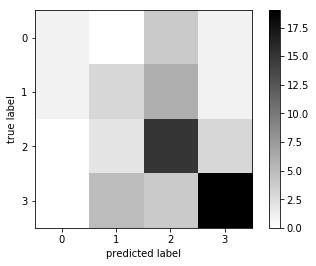

In [48]:
plot_confusion_matrix(*get_preds_nad_true())

(array([ 6.,  0.,  0., 11.,  0.,  0., 20.,  0.,  0., 28.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

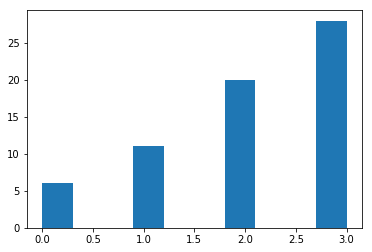

In [49]:
plt.hist(data["axis_id"].values[valid_idx])

(array([ 75.,   0.,   0.,  74.,   0.,   0., 249.,   0.,   0., 196.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

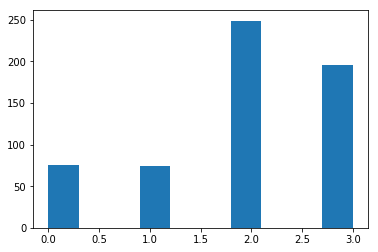

In [50]:
plt.hist(data["axis_id"].values[train_idx])

(array([ 482.,    0.,    0.,  459.,    0.,    0., 1474.,    0.,    0.,
        1227.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

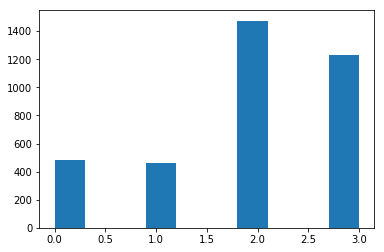

In [75]:
plt.hist([train_dataset.data[x, -1] for x in np.array(train_dataset.cut_points, dtype=np.int32)[:,0]])

In [74]:
print(np.array(train_dataset.cut_points, dtype=np.int32)[:,0], )

[  0   0   0 ... 593 593 593]


In [35]:
F.softmax(torch.tensor([[2.0,3.0], [1.0, 3.0]]).float(), dim  = 1)

tensor([[0.2689, 0.7311],
        [0.1192, 0.8808]])

In [36]:
np.array([[2,3],[2,2],[1,2]]).shape

(3, 2)